# EZ: Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import glob as glob
import pdf_ccdf
import h5py
import sys
sys.path.append('/home/santiago_b/ez_model/src/')
import model as ez

In [2]:
plt.rcParams.update({'font.size': 20})
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["font.serif"] = "Times New Roman"

In [3]:
# Threshold
def onoff_dist(T,dt,thresh):
    wt = []
    t_off = dt
    for q in T:
        if (q<=thresh):
            t_off += dt
        else:
            wt.append(t_off)
            t_off = dt

    return np.array(wt)

In [4]:
# Choose output directory
odir = './Figures/'

In [5]:
np.logspace(-2,-1.1,6)

array([0.01      , 0.01513561, 0.02290868, 0.03467369, 0.05248075,
       0.07943282])

## List of $q_{in}$ values

In [10]:
q_ins_Ny = []
for idir in [
    '../old_runs_master/400x80/', # only q>0.1
    '../old_runs_master/200x40/', 
    '../old_runs_master/400x40/', 
    '../old_runs_master/800x40/',
    '../old_runs_master/128x128/',
    '../old_runs_master/256x256/',
]:
    dirs = sorted(glob.glob(idir+'q*'))
    
    Ny = float(idir.split('x')[1][:-1])
    
    runs = []
    for file in dirs:
        run = file.split('/')[3]
        q_in = float(run.split('_')[1].replace('d','.'))
        if q_in<1:
            q_in_real = 1/int(1/q_in)
    #         print("q_in real",q_in_real)
        else:
            q_in_real = int(q_in)
    #         print("q_in > 1",int(q_in))
        q_ins_Ny.append(q_in_real/Ny)

q_ins_Ny = np.unique(np.array(q_ins_Ny))
print(q_ins_Ny)

[1.25000000e-04 1.89393939e-04 2.50000000e-04 2.90697674e-04
 3.78787879e-04 3.90625000e-04 4.46428571e-04 5.58035714e-04
 5.81395349e-04 6.57894737e-04 7.81250000e-04 8.92857143e-04
 1.04166667e-03 1.11607143e-03 1.25000000e-03 1.30208333e-03
 1.31578947e-03 1.56250000e-03 1.78571429e-03 1.95312500e-03
 2.08333333e-03 2.50000000e-03 2.60416667e-03 3.57142857e-03
 3.90625000e-03 4.16666667e-03 5.00000000e-03 6.25000000e-03
 7.81250000e-03 8.33333333e-03 1.17187500e-02 1.25000000e-02
 1.56250000e-02 1.95312500e-02 2.34375000e-02 2.50000000e-02
 2.73437500e-02 3.75000000e-02 3.90625000e-02 5.00000000e-02
 5.46875000e-02 6.25000000e-02 7.50000000e-02 7.81250000e-02
 8.75000000e-02 1.25000000e-01 1.75000000e-01 2.50000000e-01]


In [11]:
for run in runs[-2:-1]:
    fname = str(glob.glob(idir+run+'/*_scalars.h5')[0])
    f = h5py.File(fname,'r')
    print(run)
    for subdat in f:
        print(subdat)
        print(f[subdat].keys())
#         print(subdat['tasks'].keys())
#         print(subdat['scales']['sim_time'][:])
    f.close()

In [12]:
# Scale for coloring:
def cscale_qins(q_in,q_ins_Ny):
    maxt = np.log10(np.max(q_ins_Ny))
    mint = np.log10(np.min(q_ins_Ny))
    return (np.log10(q_in) - mint)/(maxt-mint)

# Time series

$$ q^*_{in} = \frac{q_{in}}{\tilde{\Delta t}_{s}} \frac{4}{3} \pi \frac{1}{\tilde{b}} \left(\frac{\rho_w}{\rho_s - \rho_w}\right)^{1/2}$$

## Bed slopes

In [9]:
plot_yn = False

In [13]:
slopes_bed = dict([])
qin_reals_bed = dict([])
for idir in [
    '../old_runs_master/400x80/', # only q>0.1
    '../old_runs_master/200x40/', 
    '../old_runs_master/400x40/', 
    '../old_runs_master/800x40/',
    '../old_runs_master/128x128/',
    '../old_runs_master/256x256/',
]:
    print("Working on %s" % idir)
    slopes_l = []
    q8s_l = []
    
    dirs = sorted(glob.glob(idir+'q*'))

    runs = []
    for file in dirs:
        run = file.split('/')[3]
        q_in = float(run.split('_')[1].replace('d','.'))
#         if ((q_in<0.1)&(idir=='../400x80/') or (q_in<0.1)&(idir=='../400x40/')):
#         if ((q_in<0.02)&(idir=='../400x80/')):
#             print("Skipping %s" % run)
#             pass
#         else:
        runs.append(run)

    # Sort run-names based on value of q_in
    runs = sorted(runs, key=lambda x: float(x.split('_')[1].replace('d','.')), reverse=False)
    
    for ii,run in enumerate(runs):
        # Open 
        fname = str(glob.glob(idir+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]
        file.close()

        # Initialize
        set_q = ez.set_q(Nx, Ny, c_0, f, skipmax,q_in)

        # Load data:
        set_q.load_data(str(glob.glob(idir+run+'/*_state.h5')[0]))

        # Plot
#         print("q_in = %s" % q_in)

        if q_in<1:
            q_in_real = 1/int(1/q_in)
#             print("q_in real",q_in_real)
        else:
            q_in_real = int(q_in)
#             print("q_in > 1",int(q_in))
        q8s_l.append(q_in_real)
    #     set_q.plot_min()

        z_avg = np.mean(set_q.z[:,5:-5],axis=0)
        x = np.arange(len(z_avg))
        m,b = np.polyfit(x,z_avg,1)
        slopes_l.append(m)
        
    slopes_bed['%sx%s' % (Nx,Ny)] = np.array(slopes_l)
    qin_reals_bed['%sx%s' % (Nx,Ny)] = np.array(q8s_l)


Working on ../old_runs_master/400x80/


TypeError: __init__() missing 1 required positional argument: 'q_in'

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


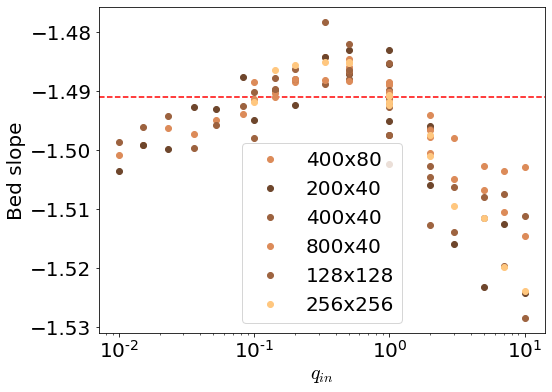

In [11]:
plt.figure(figsize=(8,6))
slope_c = np.sqrt((1/((2.785*set_q.c_0)**2))-1)
plt.axhline(y=-slope_c,c='r',ls='--')
for dirr in slopes_bed:
    Nx = float(dirr.split('x')[0])
    Ny = float(dirr.split('x')[1])
    plt.semilogx(qin_reals_bed[dirr],slopes_bed[dirr],marker = 'o',c=cm.copper(np.sqrt(Nx*Ny/(256**2))),ls='',label = dirr)
plt.legend()
# plt.xlabel("$q^*_{in}$")
plt.xlabel("$q_{in}$")
plt.ylabel("Bed slope")
# plt.title("Measuring Bed Activity")
plt.show()

## Bed activity PDF

In [13]:
plot_yn = False

In [14]:
slopes_ba = dict([])
qin_reals_ba = dict([])
for idir in [
    '../400x80/', # only q>0.1
    '../200x40/', 
    '../400x40/', 
    '../800x40/',
    '../128x128/',
    '../256x256/',
]:
    print("Working on %s" % idir)
    slopes_l = []
    q8s_l = []
    
    dirs = sorted(glob.glob(idir+'q*'))

    runs = []
    for file in dirs:
        run = file.split('/')[2]
        q_in = float(run.split('_')[1].replace('d','.'))
        if ((q_in<0.1)&(idir=='../400x80/')):
#         if ((q_in<0.02)&(idir=='../400x80/')):
            print("Skipping %s" % run)
            pass
        else:
            runs.append(run)

    # Sort run-names based on value of q_in
    runs = sorted(runs, key=lambda x: float(x.split('_')[1].replace('d','.')), reverse=False)
    
    for ii,run in enumerate(runs):
#         print("Working on run %s" % run)
        # Open 
        fname = str(glob.glob(idir+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')

        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]
        rho = 0.8
        dt = file['parameters']['dt'][()]
        if q_in<1:
            q_in_real = 1/int(1/q_in)
    #         print("q_in real",q_in_real)
        else:
            q_in_real = int(q_in)
    #         print("q_in > 1",int(q_in))

        # Normalize
        norm = dt**-1 * (4/3.) * np.pi * 1/float(Ny) * rho
        q8_in = norm*q_in_real

        # Get time-series ['bed_activity', 'q_out', 'time', 'tstep']
        time = file['scalars']['time'][()]
        tstep = file['scalars']['tstep'][()]
        q_out = file['scalars']['q_out'][()]
        q8_out = q_out*norm
        bed_activity = file['scalars']['bed_activity'][()]

        # Close file:
        file.close()

    #     if (q_in_real<3):
        nbin = 20

        # Choose data to plot:
        q = bed_activity

        pdf, x = pdf_ccdf.pdf_ccdf(q[q>0], n=nbin,output='pdf')#,xmin = 2e-3,xmax = max(q), output='pdf')

        # Finite size effect cutoff
        nbeads = 3# Number of grains considered 'too small'
        xcutoff = nbeads/(Nx*Ny) # Five grains active total

        xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)

#         if idir=='../256x256/':
        if plot_yn:
            plt.figure(figsize=(8,6))
            plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))
            plt.loglog(x,pdf,marker='x',ls='',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, %sx%s" % (q8_in,Nx,Ny),ms=10)
        
        # Fit
        if ((idir=='../400x80/') or (idir=='../128x128/')):
            fitmax = 7e-4  # For 200x40
        elif (idir=='../256x256/'):
            fitmax = 4e-4
        elif (idir=='../200x40/'):
            fitmax = 2e-3
        else:
            fitmax = 1e-3  # For 400x80
        fitmin = xcutoff 
        xfit = x[(x<fitmax)&(x>fitmin)&(pdf>0)]
        pdffit = pdf[(x<fitmax)&(x>fitmin)&(pdf>0)]
#         print(idir, run)
        m,b = np.polyfit(np.log10(xfit),np.log10(pdffit),1)
#         if idir=='../256x256/':
        xpl = np.logspace(np.log10(fitmin),np.log10(fitmax),100)
        if plot_yn:
            plt.plot(xpl,10**b*xpl**(m),'--r',label =r"Fit, $n^{%.2f}$" % m,lw=2)
            plt.legend()#loc=(1.01,0.0))
            plt.xlabel(r"Bed Activity")
            plt.xlabel(r"$q_{out}$")
        slopes_l.append(m)
        q8s_l.append(q_in_real)
#         else:
#             plt.figure(figsize=(8,6))
#             plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))
#             plt.loglog(x,pdf,marker='.',ls='',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, 400x80" % (q8_in),ms=10)
#             slopes_ba_400.append(m)
#             q8_ins_ba_400.append(q8_in)

        if plot_yn:
            plt.show()
            plt.close()
        
    slopes_ba['%sx%s' % (Nx,Ny)] = np.array(slopes_l)
    qin_reals_ba['%sx%s' % (Nx,Ny)] = np.array(q8s_l)


Working on ../400x80/
Skipping q_1d000000e-02
Skipping q_1d513561e-02
Skipping q_2d290868e-02
Skipping q_3d467369e-02
Skipping q_5d248075e-02
Skipping q_7d943282e-02
Working on ../200x40/
Working on ../400x40/
Working on ../800x40/
Working on ../128x128/
Working on ../256x256/


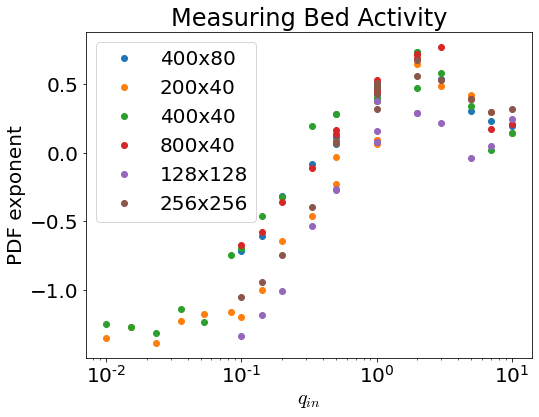

In [16]:
plt.figure(figsize=(8,6))
# plt.semilogx(q8_ins_ba,slopes_ba,'ok')
for dirr in slopes_ba:
    Nx = float(dirr.split('x')[0])
    Ny = float(dirr.split('x')[1])
    plt.semilogx(qin_reals_ba[dirr],slopes_ba[dirr],marker = 'o',ls='',label = dirr)
plt.legend()
# plt.xlabel("$q^*_{in}$")
plt.xlabel("$q_{in}$")
plt.ylabel("PDF exponent")
plt.title("Measuring Bed Activity")
plt.show()

## Max values as a function of size

In [46]:
max_ba = dict([])
qin_reals_ba = dict([])
for idir in [
    '../400x80/', # only q>0.1
    '../200x40/', 
    '../400x40/', 
    '../800x40/',
    '../128x128/',
    '../256x256/',
]:
    print("Working on %s" % idir)
    slopes_l = []
    q8s_l = []
    
    dirs = sorted(glob.glob(idir+'q*'))

    runs = []
    for file in dirs:
        run = file.split('/')[2]
        q_in = float(run.split('_')[1].replace('d','.'))
        if ((q_in<0.1)&(idir=='../400x80/')):
#         if ((q_in<0.02)&(idir=='../400x80/')):
            print("Skipping %s" % run)
            pass
        else:
            runs.append(run)

    # Sort run-names based on value of q_in
    runs = sorted(runs, key=lambda x: float(x.split('_')[1].replace('d','.')), reverse=False)
    
    for ii,run in enumerate(runs):
#         print("Working on run %s" % run)
        # Open 
        fname = str(glob.glob(idir+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')

        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]
        rho = 0.8
        dt = file['parameters']['dt'][()]
        if q_in<1:
            q_in_real = 1/int(1/q_in)
    #         print("q_in real",q_in_real)
        else:
            q_in_real = int(q_in)
    #         print("q_in > 1",int(q_in))

        # Normalize
        norm = dt**-1 * (4/3.) * np.pi * 1/float(Ny) * rho
        q8_in = norm*q_in_real

        # Get time-series ['bed_activity', 'q_out', 'time', 'tstep']
        time = file['scalars']['time'][()]
        tstep = file['scalars']['tstep'][()]
        q_out = file['scalars']['q_out'][()]
        q8_out = q_out*norm
        bed_activity = file['scalars']['bed_activity'][()]

        # Close file:
        file.close()

        ba_max = np.max(q_out)
        
    #     if (q_in_real<3):
#         nbin = 20

#         # Choose data to plot:
#         q = bed_activity

#         pdf, x = pdf_ccdf.pdf_ccdf(q[q>0], n=nbin,output='pdf')#,xmin = 2e-3,xmax = max(q), output='pdf')

#         # Finite size effect cutoff
#         nbeads = 3# Number of grains considered 'too small'
#         xcutoff = nbeads/(Nx*Ny) # Five grains active total

#         xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)

# #         if idir=='../256x256/':
#         if plot_yn:
#             plt.figure(figsize=(8,6))
#             plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))
#             plt.loglog(x,pdf,marker='x',ls='',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, %sx%s" % (q8_in,Nx,Ny),ms=10)
        
#         # Fit
#         if ((idir=='../400x80/') or (idir=='../128x128/')):
#             fitmax = 7e-4  # For 200x40
#         elif (idir=='../256x256/'):
#             fitmax = 4e-4
#         elif (idir=='../200x40/'):
#             fitmax = 2e-3
#         else:
#             fitmax = 1e-3  # For 400x80
#         fitmin = xcutoff 
#         xfit = x[(x<fitmax)&(x>fitmin)&(pdf>0)]
#         pdffit = pdf[(x<fitmax)&(x>fitmin)&(pdf>0)]
# #         print(idir, run)
#         m,b = np.polyfit(np.log10(xfit),np.log10(pdffit),1)
# #         if idir=='../256x256/':
#         xpl = np.logspace(np.log10(fitmin),np.log10(fitmax),100)
#         if plot_yn:
#             plt.plot(xpl,10**b*xpl**(m),'--r',label =r"Fit, $n^{%.2f}$" % m,lw=2)
#             plt.legend()#loc=(1.01,0.0))
#             plt.xlabel(r"Bed Activity")
#             plt.xlabel(r"$q_{out}$")
        if q_in_real>=1:
            slopes_l.append(ba_max)
            q8s_l.append(q_in_real)
# #         else:
# #             plt.figure(figsize=(8,6))
# #             plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))
# #             plt.loglog(x,pdf,marker='.',ls='',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, 400x80" % (q8_in),ms=10)
# #             slopes_ba_400.append(m)
# #             q8_ins_ba_400.append(q8_in)

#         if plot_yn:
#             plt.show()
#             plt.close()
        
    max_ba['%sx%s' % (Nx,Ny)] = np.array(slopes_l)
    qin_reals_ba['%sx%s' % (Nx,Ny)] = np.array(q8s_l)


Working on ../400x80/
Skipping q_1d000000e-02
Skipping q_1d513561e-02
Skipping q_2d290868e-02
Skipping q_3d467369e-02
Skipping q_5d248075e-02
Skipping q_7d943282e-02
Working on ../200x40/
Working on ../400x40/
Working on ../800x40/
Working on ../128x128/
Working on ../256x256/


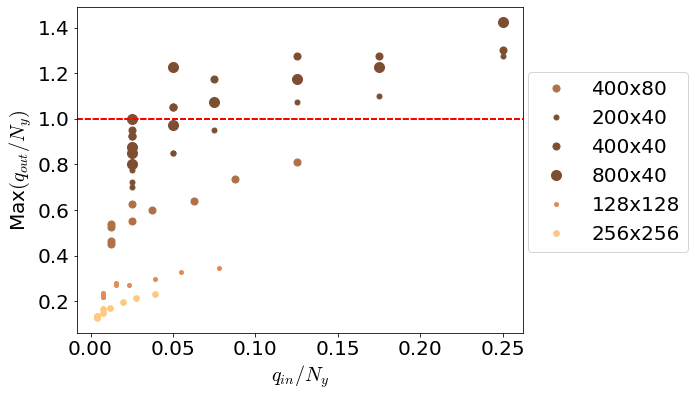

In [54]:
plt.figure(figsize=(8,6))
for dirr in max_ba:
    Nx = float(dirr.split('x')[0])
    Ny = float(dirr.split('x')[1])
    plt.axhline(y=1,c='r',ls='--')
    plt.plot(qin_reals_ba[dirr]/Ny,max_ba[dirr]/Ny,marker = 'o',c=cm.copper(np.sqrt(Ny/256)),ms=10*np.sqrt(Nx/800),ls='',label = dirr)
plt.legend(loc=(1.01,0.25))
# plt.xlabel("$q^*_{in}$")
plt.xlabel("$q_{in}/N_y$")
plt.ylabel(r"Max$(q_{out}/N_y)$")
# plt.title("Measuring Bed Activity")
plt.show()

Seems to depend mostly on $N_y$ (coloring) -- even for $q_{in}/N_y$ being equal, if $N_y$ is smaller, the maximum value found is a larger fraction of $N_y$.

If $N_y$ determined the max $q_{out}$, then $q_{out,max}/N_y = 1$ so that all of these should be close to 1, but it seems like those with large $N_y$ don't get close to that. This is true regardless of whether they avalanches merge or not. This means that we expect $q_{out,max}/N_y$ to be independent of $N_y$ _and_ $q_{in}/N_y$. 

On the other hand, if the maximum size of a single avalanche (in terms of grain widths) was _fixed_, say $N_{y,max}$ then we would find that, for each q_in dropped, that would cause an avalanche of that size. So for $q_{in} \geq 1$, we have: $q_{out,max} = q_{in}*N_{y,max}$. Therefore $q_{out,max}/N_y = q_{in} N_{y,max} / N_y$, and so we expect $q_{out,max}/N_y$ to be linear in $q_{in}/N_y$. There is a hint that that is actually what we see! This is good to see. However, it also predicts that it should be _independent_ of $N_y$. But we don't see that, why?

It's because we're assuming that the avalanches don't overlap! There are less likely to overlap for large $N_y$, but more likely to overlap for small $N_y$. In fact, it depends on what $N_{y,max} / N_y$ is. If $q_{in} N_{y,max} >\approx N_y$, then the avalanches will overlap and we'll approach 1 anyways. If $q_{in} N_{y,max} < N_y$, then we should see the scaling. Therefore $q_{out,max}/N_y$.

**TODO:** Will be re-doing runs with latest update. Making sure to output activity in a single row, rather than q_out, which depends also on hop lengths (which is why we see q_out/Ny > 1).

One issue with this comparison is that we're not sure that the size is "saturated" at this point, so maybe if $N_x$ was larger then it will lead to getting closer to 1. 
Is there any $N_x$ dependence, though? 

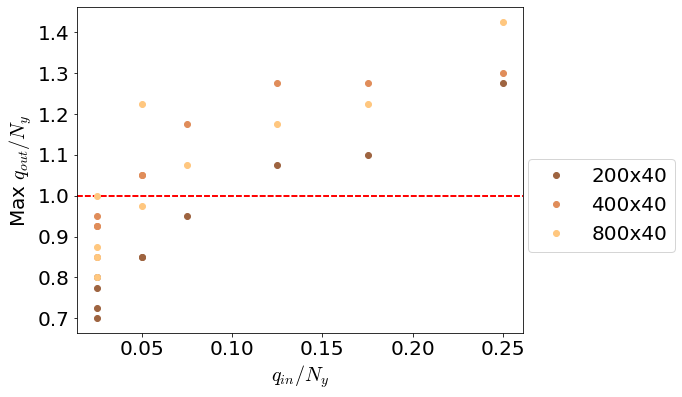

In [49]:
plt.figure(figsize=(8,6))
for dirr in max_ba:
    Nx = float(dirr.split('x')[0])
    Ny = float(dirr.split('x')[1])
    if Ny==40:
        plt.axhline(y=1,c='r',ls='--')
        plt.plot(qin_reals_ba[dirr]/Ny,max_ba[dirr]/Ny,marker = 'o',c=cm.copper(np.sqrt(Nx/(800))),ls='',label = dirr)
plt.legend(loc=(1.01,0.25))
# plt.xlabel("$q^*_{in}$")
plt.xlabel("$q_{in}/N_y$")
plt.ylabel(r"Max $q_{out}/N_y$")
# plt.title("Measuring Bed Activity")
plt.show()

Doesn't seem to clearly depend on $N_x$, at least for $N_y = 40$...

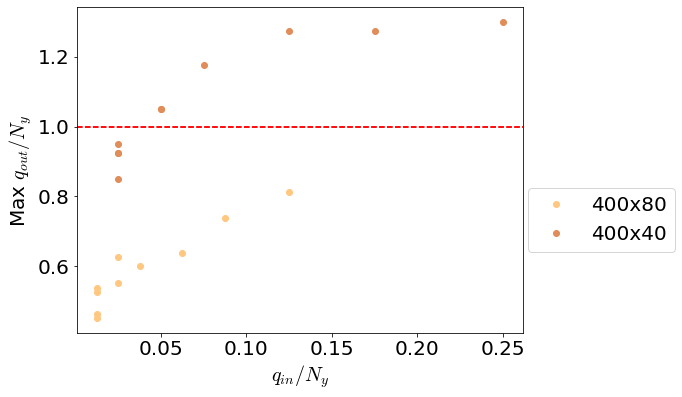

In [50]:
plt.figure(figsize=(8,6))
for dirr in max_ba:
    Nx = float(dirr.split('x')[0])
    Ny = float(dirr.split('x')[1])
    if Nx==400:
        plt.axhline(y=1,c='r',ls='--')
        plt.plot(qin_reals_ba[dirr]/Ny,max_ba[dirr]/Ny,marker = 'o',c=cm.copper(np.sqrt(Ny/(80))),ls='',label = dirr)
plt.legend(loc=(1.01,0.25))
# plt.xlabel("$q^*_{in}$")
plt.xlabel("$q_{in}/N_y$")
plt.ylabel(r"Max $q_{out}/N_y$")
# plt.title("Measuring Bed Activity")
plt.show()

## $q^*_{out}$ PDF

Working on ../128x128/


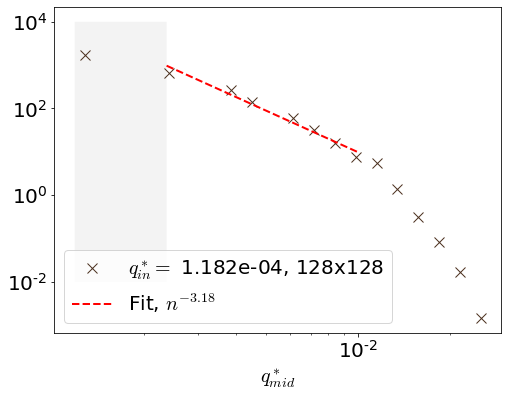

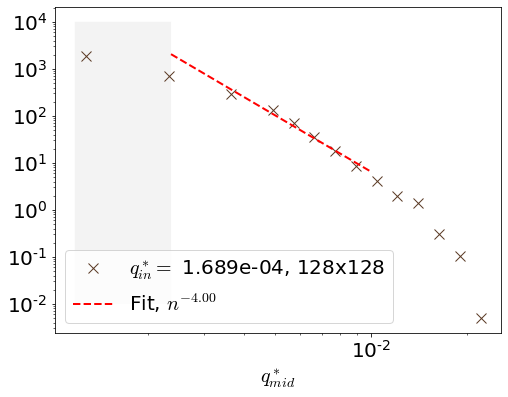

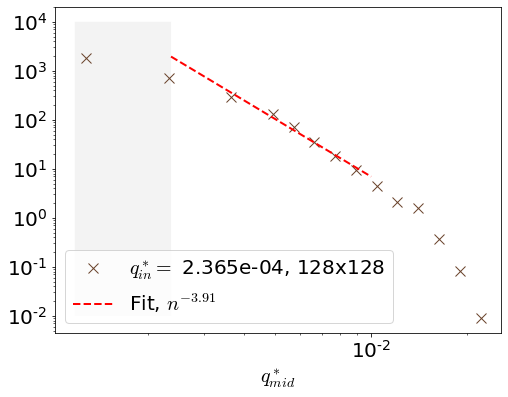

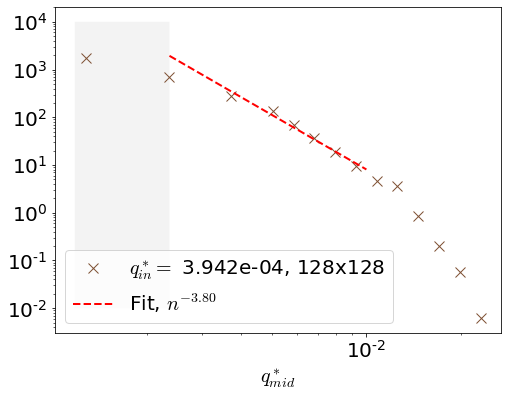

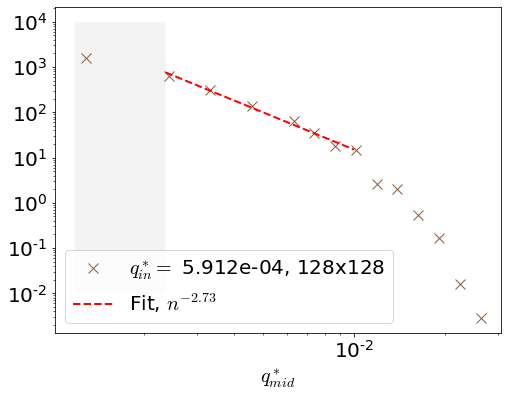

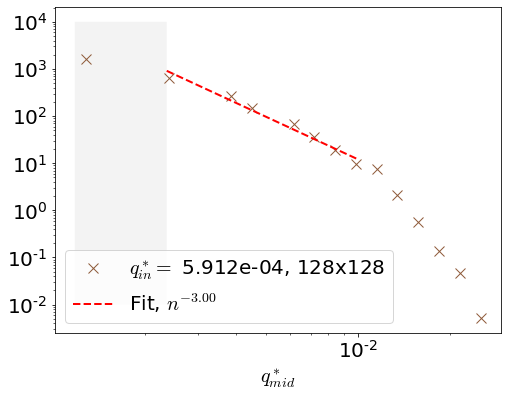

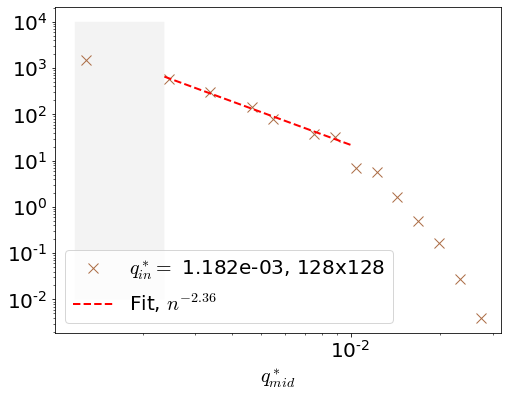

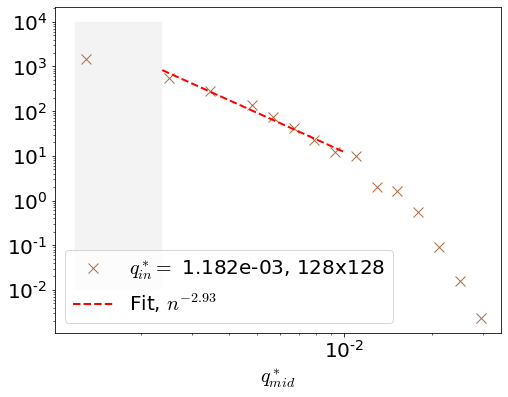

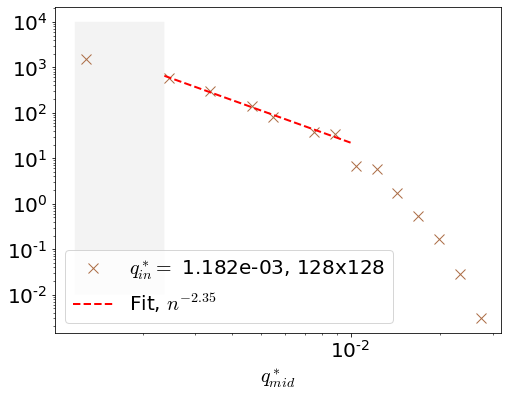

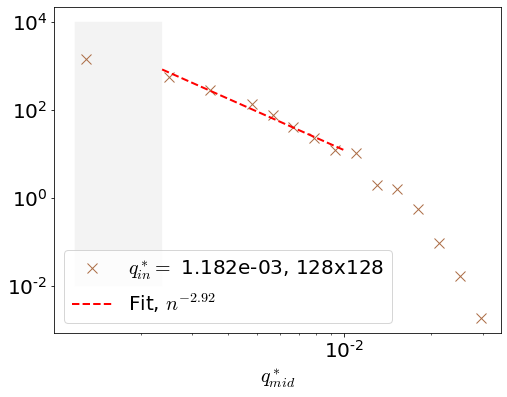

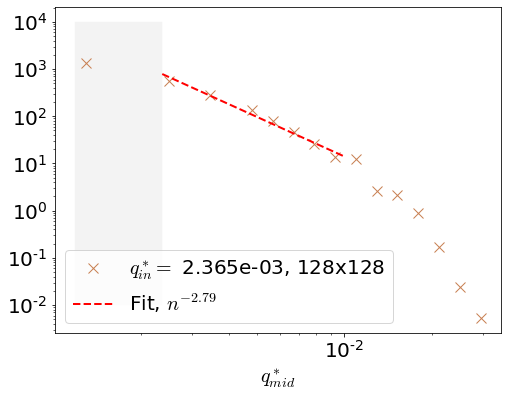

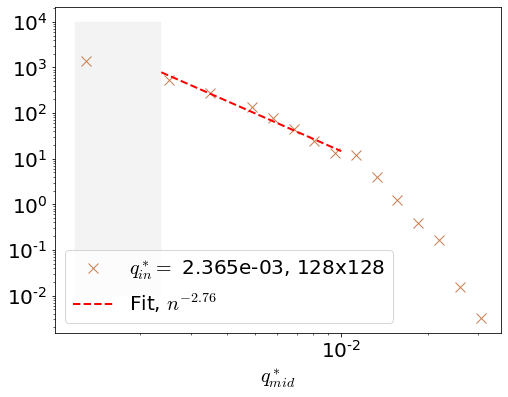

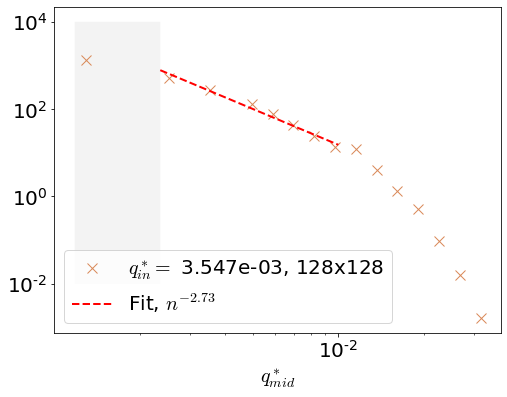

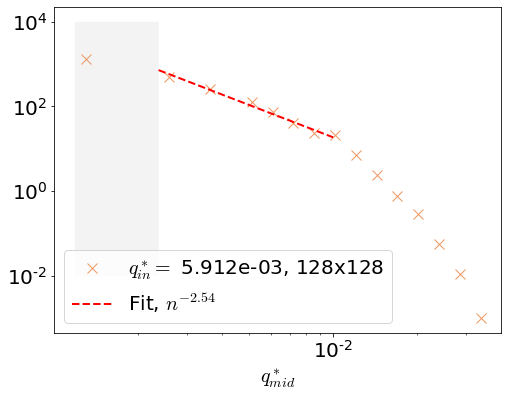

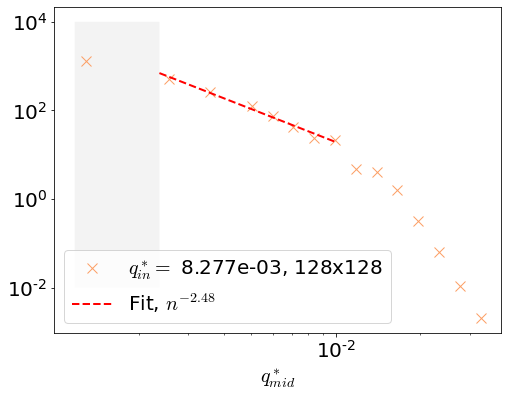

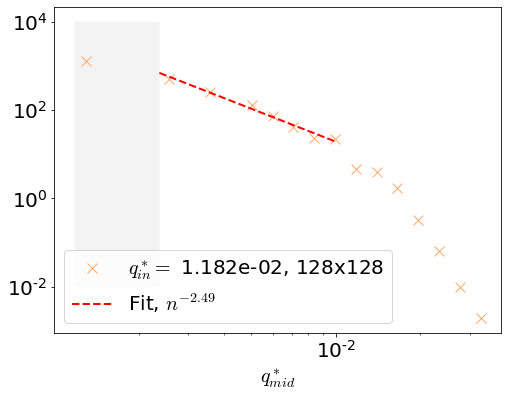

Working on ../256x256/


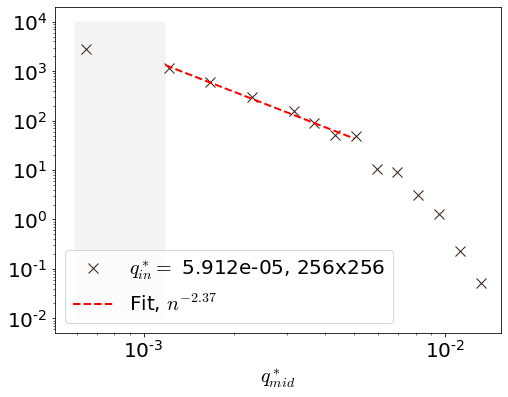

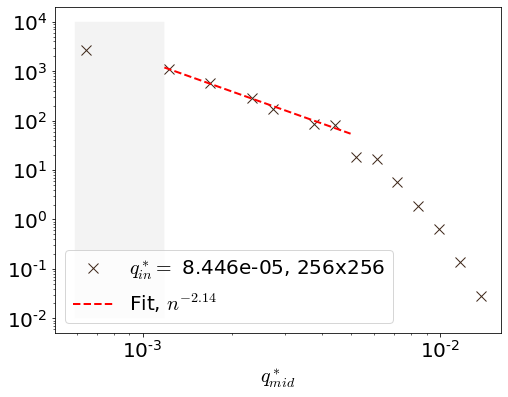

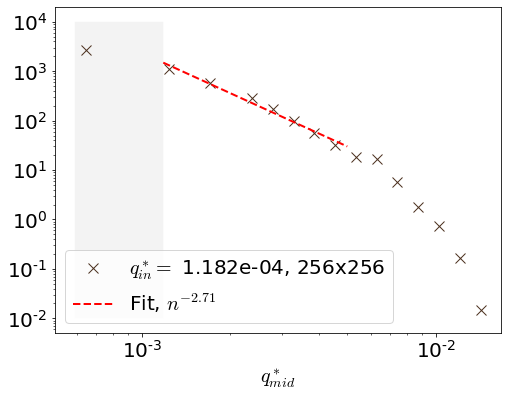

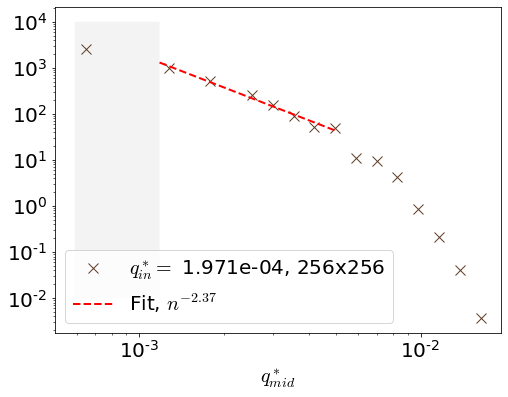

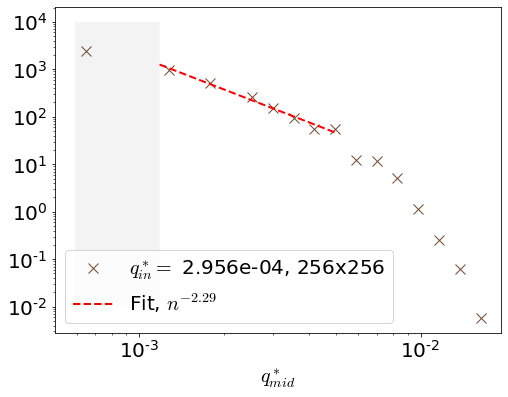

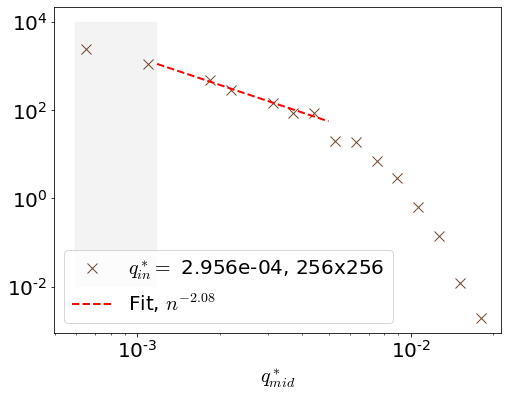

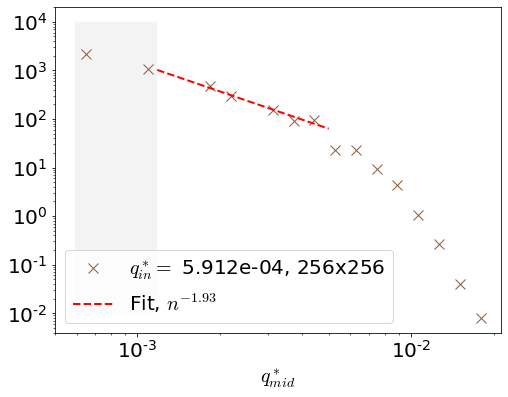

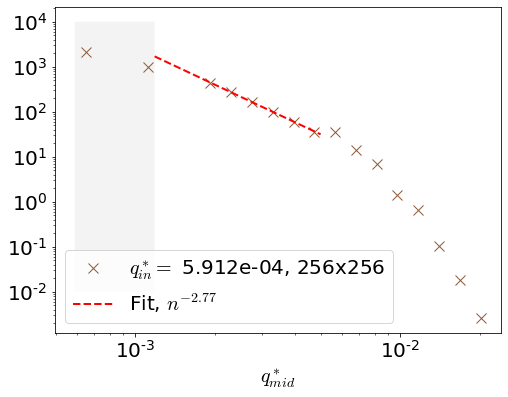

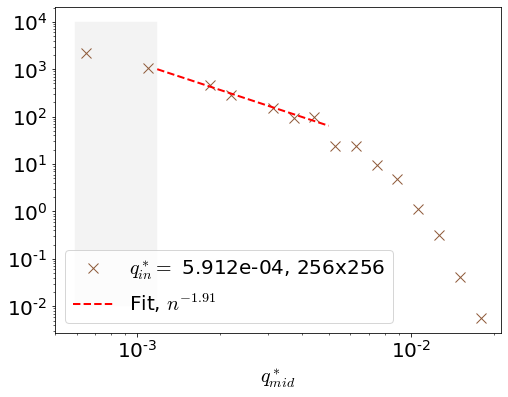

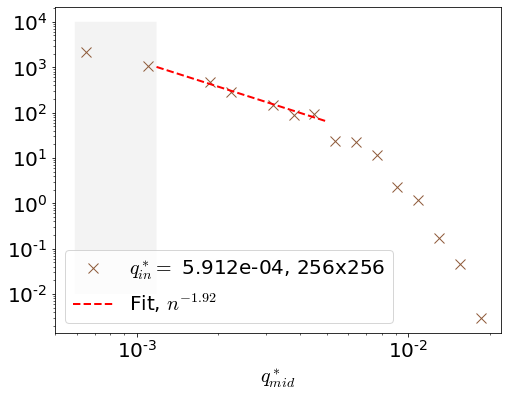

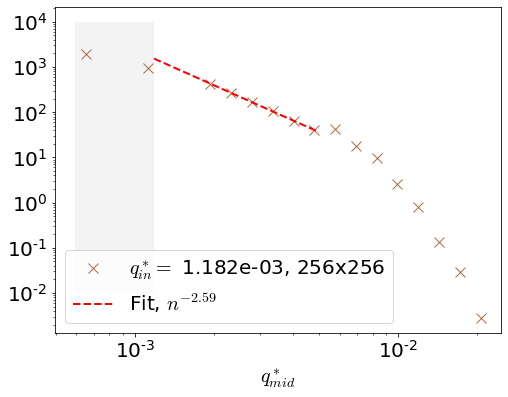

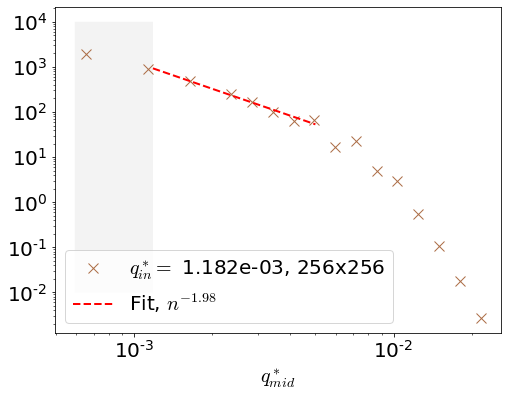

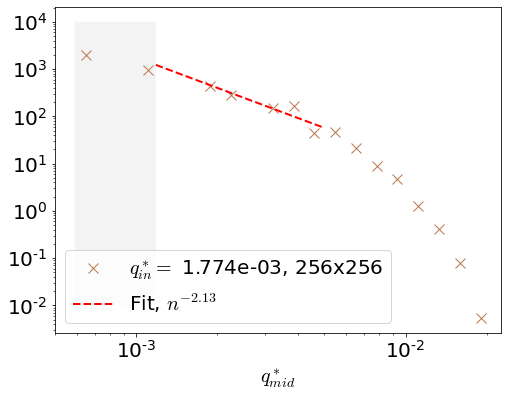

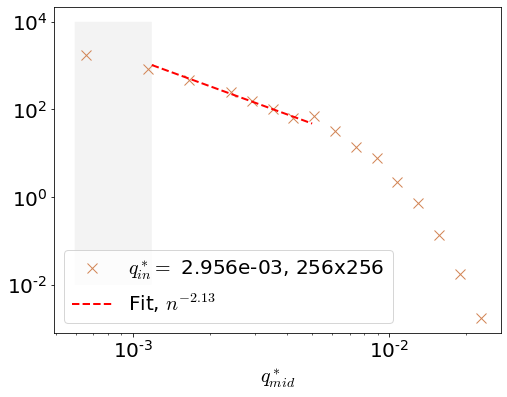

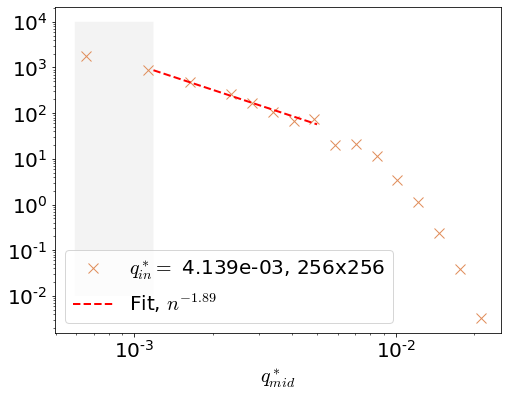

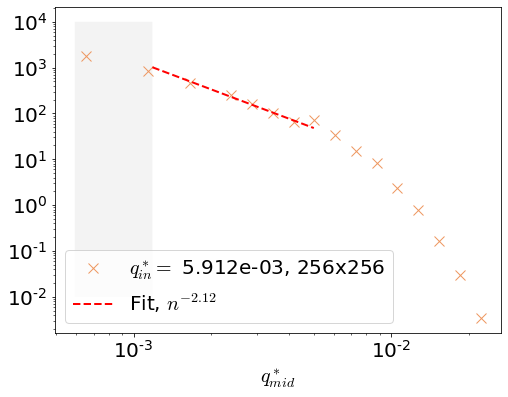

In [24]:
slopes_ba = dict([])
qin_reals_ba = dict([])
for idir in [
#     '../400x80/',
#     '../200x40/',
#     '../400x40/',
    '../128x128/',
    '../256x256/',
]:
    print("Working on %s" % idir)
    slopes_l = []
    q8s_l = []
    
    dirs = sorted(glob.glob(idir+'q*'))

    runs = []
    for file in dirs:
        run = file.split('/')[2]
        q_in = float(run.split('_')[1].replace('d','.'))
        if ((q_in<0.1)&(idir=='../400x80/') or (q_in<0.1)&(idir=='../400x40/')):
            pass
        else:
            runs.append(run)

    # Sort run-names based on value of q_in
    runs = sorted(runs, key=lambda x: float(x.split('_')[1].replace('d','.')), reverse=False)
    
    for ii,run in enumerate(runs):
        # Open 
        fname = str(glob.glob(idir+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')

        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]
        rho = 0.8
        dt = file['parameters']['dt'][()]
        if q_in<1:
            q_in_real = 1/int(1/q_in)
    #         print("q_in real",q_in_real)
        else:
            q_in_real = int(q_in)
    #         print("q_in > 1",int(q_in))

        # Normalize
        norm = dt**-1 * (4/3.) * np.pi * 1/float(Ny) * rho
        q8_in = norm*q_in_real

        # Get time-series ['bed_activity', 'q_out', 'time', 'tstep']
        time = file['scalars']['time'][()]
        tstep = file['scalars']['tstep'][()]
        q_mid = file['scalars']['q_mid'][()]
        q8_mid = q_mid*norm

        # Close file:
        file.close()

    #     if (q_in_real<3):
        nbin = 20

        # Choose data to plot:
        q = q8_mid

        pdf, x = pdf_ccdf.pdf_ccdf(q[q>0], n=nbin,output='pdf')#,xmin = 2e-3,xmax = max(q), output='pdf')

        # Finite size effect cutoff
        nbeads = 2# Number of grains considered 'too small'
        xcutoff = nbeads*norm # Five grains active total

        xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)

#         if idir=='../256x256/':
        plt.figure(figsize=(8,6))
        plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))
        plt.loglog(x,pdf,marker='x',ls='',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, %sx%s" % (q8_in,Nx,Ny),ms=10)
        
        # Fit
        if ((idir=='../400x80/') or (idir=='../128x128/')):
            fitmax = 1e-2  # For 200x40
        elif (idir=='../256x256/'):
            fitmax = 5e-3
        else:
            fitmax = 2e-3  # For 400x80
        fitmin = xcutoff 
        xfit = x[(x<fitmax)&(x>fitmin)&(pdf>0)]
        pdffit = pdf[(x<fitmax)&(x>fitmin)&(pdf>0)]
# #         print(idir, run)
        m,b = np.polyfit(np.log10(xfit),np.log10(pdffit),1)
#         if idir=='../256x256/':
        xpl = np.logspace(np.log10(fitmin),np.log10(fitmax),100)
        plt.plot(xpl,10**b*xpl**(m),'--r',label =r"Fit, $n^{%.2f}$" % m,lw=2)
        plt.legend()#loc=(1.01,0.0))
#         plt.xlabel(r"Bed Activity")
        plt.xlabel(r"$q^*_{mid}$")
        slopes_l.append(m)
        q8s_l.append(q_in_real)
#         else:
#             plt.figure(figsize=(8,6))
#             plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))
#             plt.loglog(x,pdf,marker='.',ls='',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, 400x80" % (q8_in),ms=10)
#             slopes_ba_400.append(m)
#             q8_ins_ba_400.append(q8_in)
        plt.show()
        plt.close()


    slopes_ba['%sx%s' % (Nx,Ny)] = np.array(slopes_l)
    qin_reals_ba['%sx%s' % (Nx,Ny)] = np.array(q8s_l)

        

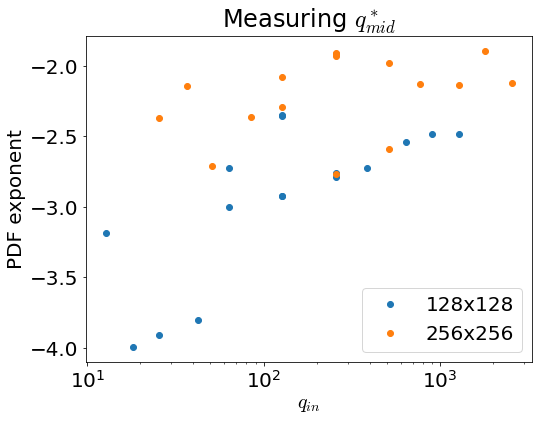

In [23]:
plt.figure(figsize=(8,6))
# plt.semilogx(q8_ins_ba,slopes_ba,'ok')
for dirr in slopes_ba:
    Nx = float(dirr.split('x')[0])
    Ny = float(dirr.split('x')[1])
    plt.semilogx(qin_reals_ba[dirr]*Nx,slopes_ba[dirr],marker = 'o',ls='',label = dirr)
plt.legend()
# plt.xlabel("$q^*_{in}$")
plt.xlabel("$q_{in}$")
plt.ylabel("PDF exponent")
plt.title(r"Measuring $q^*_{mid}$")
plt.show()

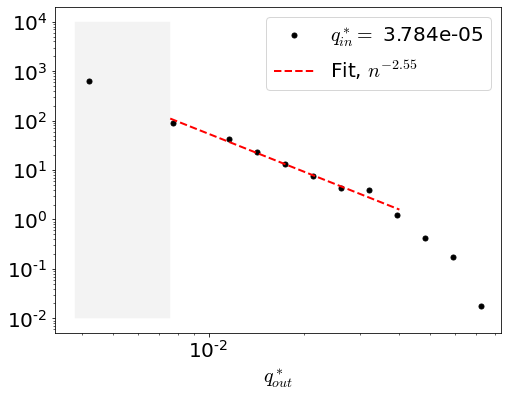

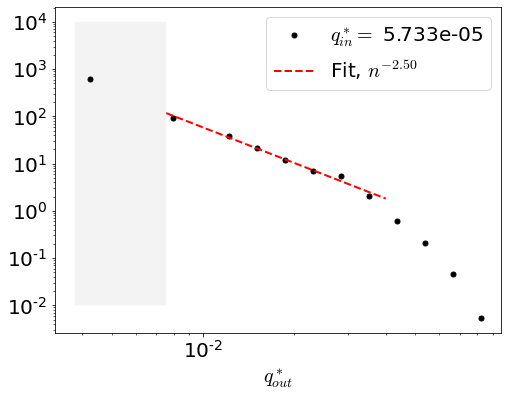

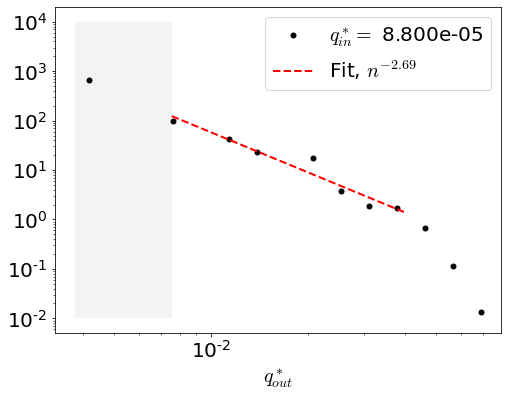

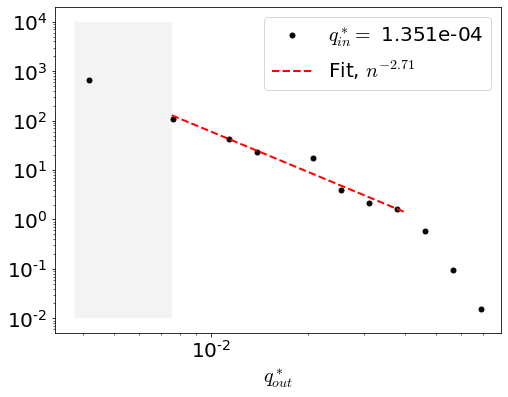

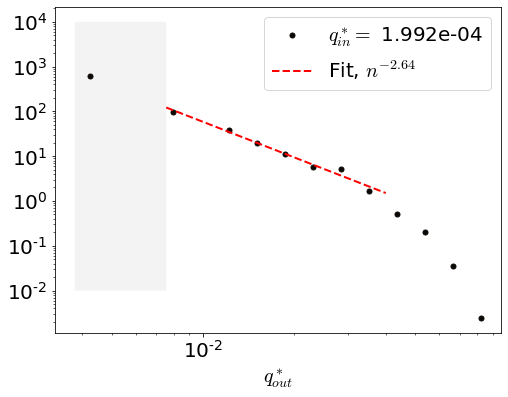

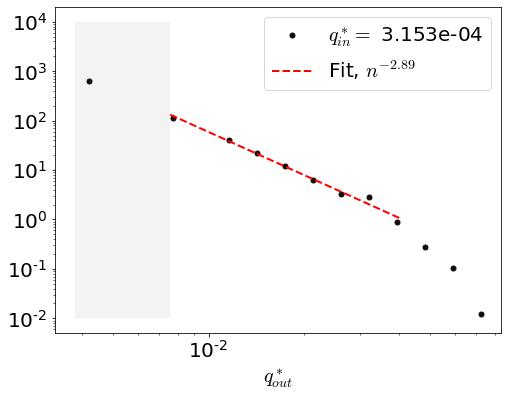

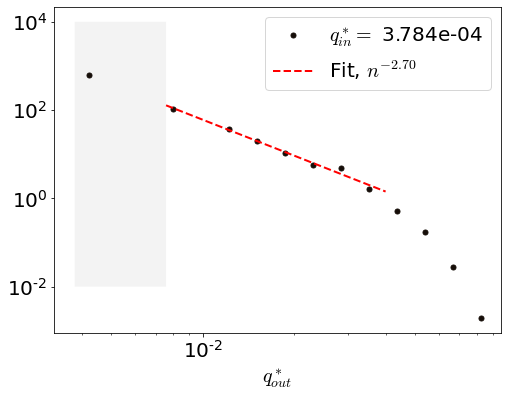

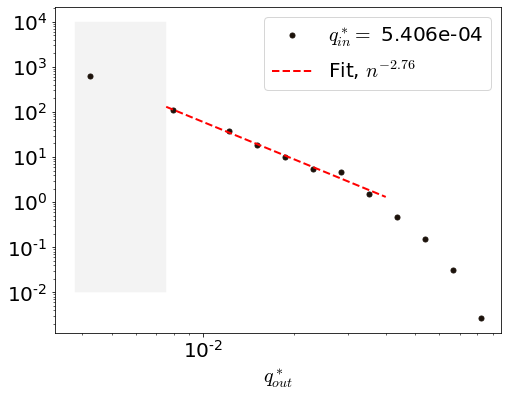

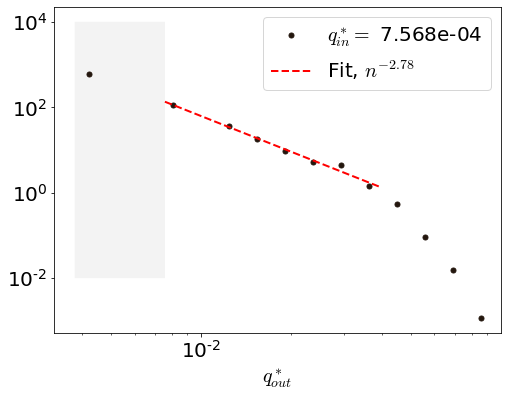

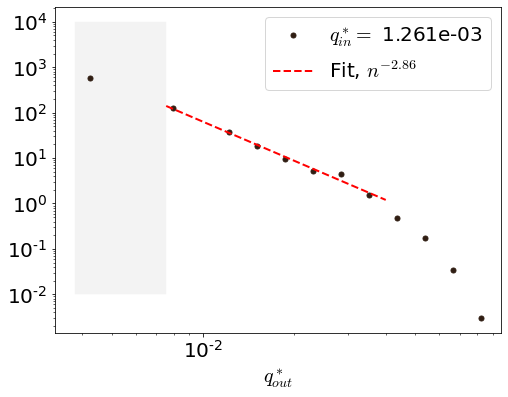

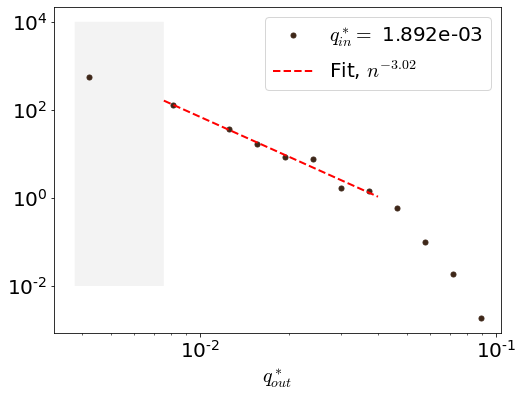

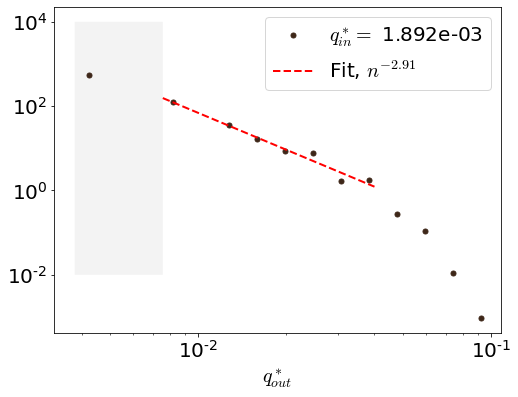

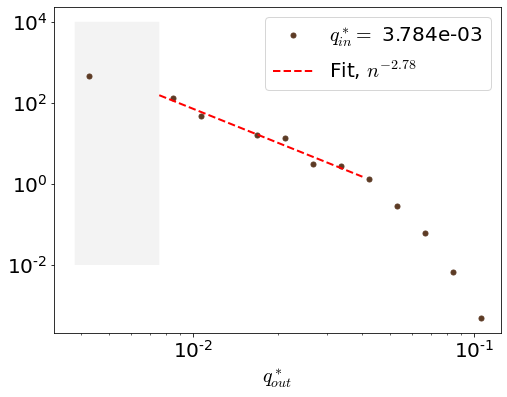

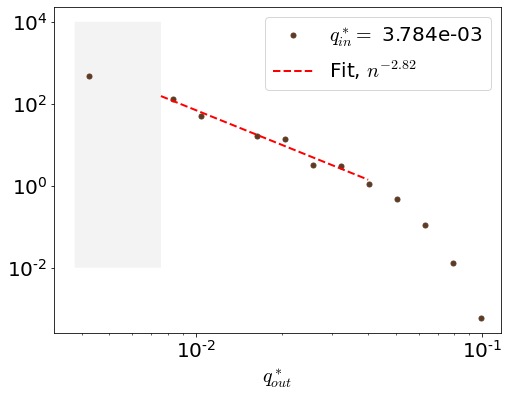

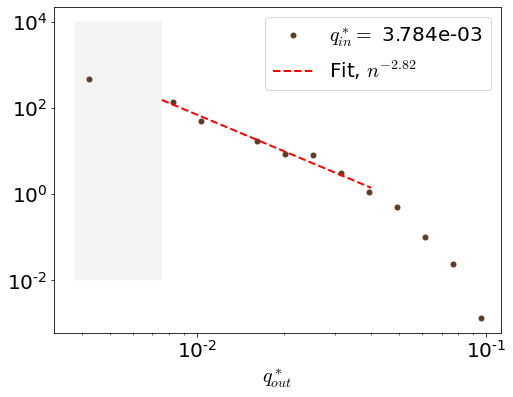

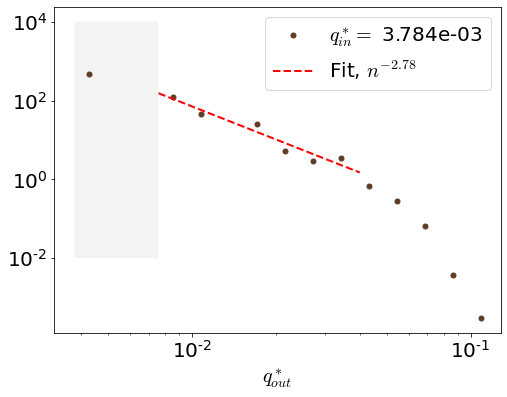

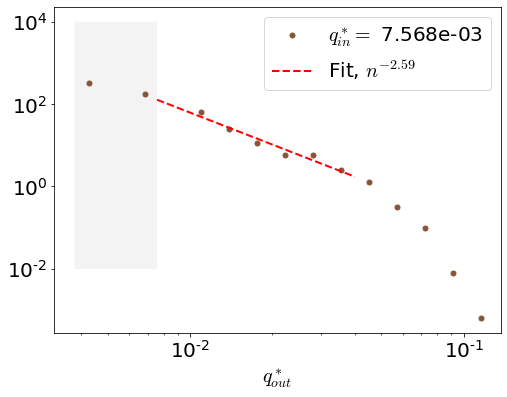

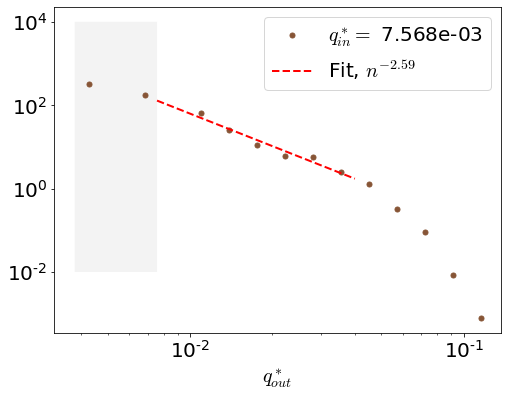

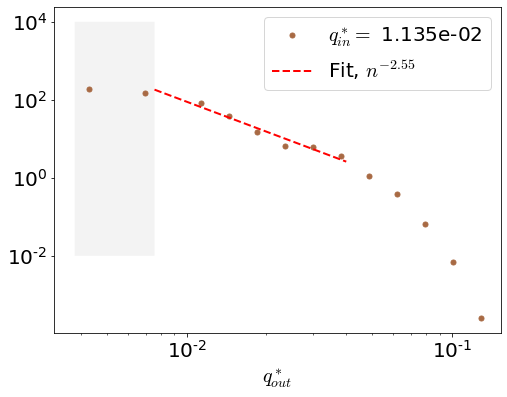

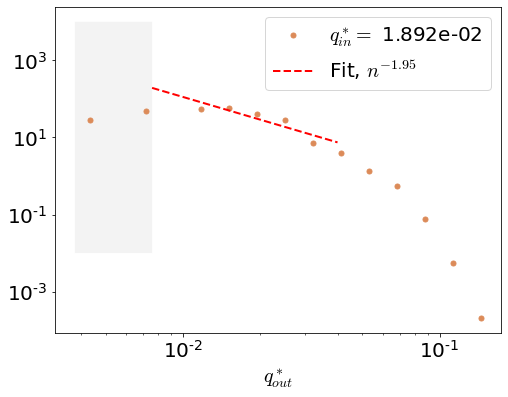

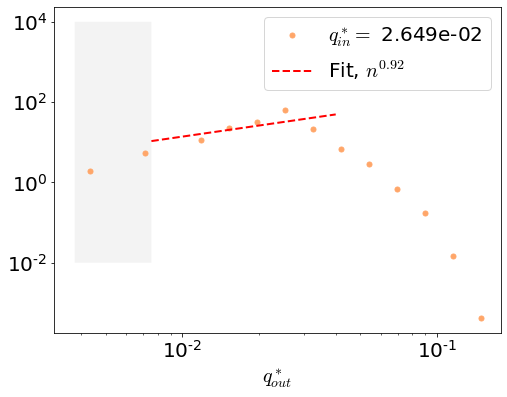

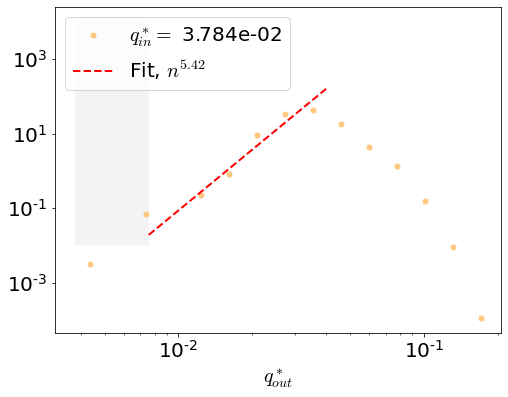

In [17]:
qm = []
qs = []
slopes_qout = []
q8_ins_qout = []
for ii,run in enumerate(runs):
    # Open 
    fname = str(glob.glob(idir+run+'/*_scalars.h5')[0])
    file = h5py.File(fname,'r')
    
    # Get parameters:
    Nx = file['parameters']['Nx'][()]
    Ny = file['parameters']['Ny'][()]
    c_0 = file['parameters']['c_0'][()]
    f = file['parameters']['f'][()]
    q_in = file['parameters']['q_in'][()]
    skipmax = file['parameters']['skipmax'][()]
    rho = 0.8
    dt = file['parameters']['dt'][()]
    if q_in<1:
        q_in_real = 1/int(1/q_in)
#         print("q_in real",q_in_real)
    else:
        q_in_real = int(q_in)
#         print("q_in > 1",int(q_in))
    
    # Normalize
    norm = dt**-1 * (4/3.) * np.pi * 1/float(Ny) * rho
    q8_in = norm*q_in_real
    
    # Get time-series ['bed_activity', 'q_out', 'time', 'tstep']
    time = file['scalars']['time'][()]
    tstep = file['scalars']['tstep'][()]
    q_out = file['scalars']['q_out'][()]
    q8_out = q_out*norm
    bed_activity = file['scalars']['bed_activity'][()]
    
    # Close file:
    file.close()
    
#     if q_in_real<3:
    nbin = 15

    # Choose data to plot:
    q = q8_out

    pdf, x = pdf_ccdf.pdf_ccdf(q[q>0], n=nbin,output='pdf')#,xmin = 2e-3,xmax = max(q), output='pdf')

    plt.figure(figsize=(8,6))    
    
    plt.loglog(x,pdf,marker='.',ls='',c = cm.copper(cscale_qins(q_in_real,qins)),label = r"$q^*_{in} =$ %.3e" % q8_in,ms=10)

    # Finite size effect cutoff
    nbeads = 2# Number of grains considered 'too small'
    xcutoff = norm*nbeads

    xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)
    plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))

    # Fit
    fitmax = 4e-2
    fitmin = xcutoff 
    xfit = x[(x<fitmax)&(x>fitmin)&(pdf>0)]
    pdffit = pdf[(x<fitmax)&(x>fitmin)&(pdf>0)]
    m,b = np.polyfit(np.log10(xfit),np.log10(pdffit),1)
    slopes_qout.append(m)
    q8_ins_qout.append(q8_in)

    xpl = np.logspace(np.log10(fitmin),np.log10(fitmax),100)
    plt.plot(xpl,10**b*xpl**(m),'--r',label =r"Fit, $n^{%.2f}$" % m,lw=2)

    xpl

    plt.legend()#loc=(1.01,0.0),fontsize=12)
    plt.xlabel(r"$q^*_{out}$")

    plt.show()
    
slopes_qout = np.array(slopes_qout)
q8_ins_qout = np.array(q8_ins_qout)

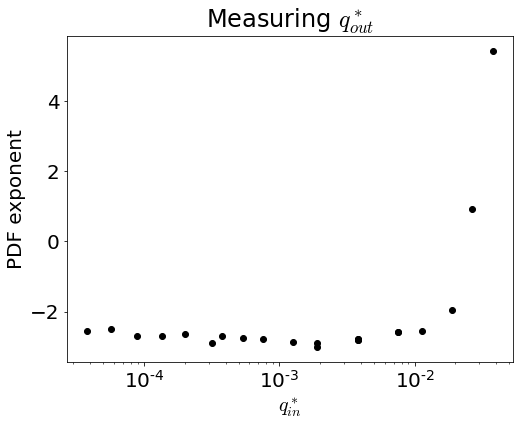

In [22]:
plt.figure(figsize=(8,6))
# plt.semilogx(q8_ins_qout[slopes_qout<-1],slopes_qout[slopes_qout<-1],'ok')
plt.semilogx(q8_ins_qout,slopes_qout,'ok')
# plt.ylim(-4,-2)
plt.xlabel("$q^*_{in}$")
plt.ylabel("PDF exponent")
plt.title("Measuring $q^*_{out}$")
plt.show()

## Waiting time PDF

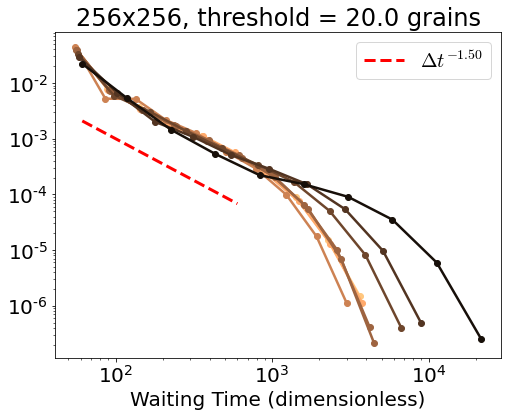

In [33]:
# Choose directory
# idir = '../200x40/'
idir = '../256x256/'
Nx = 256
Ny = 256

exp_plot= [
#     'q_1d000000e-02', 
#     'q_1d513561e-02', 
#     'q_2d290868e-02', 
#     'q_3d467369e-02', 
#     'q_5d248075e-02', 
#     'q_7d943282e-02', 
#     'q_1d000000e-01', 
    'q_1d359356e-01', 
#     'q_1d847850e-01', 
    'q_2d511886e-01', 
#     'q_3d414549e-01', 
    'q_4d641589e-01', 
#     'q_6d309573e-01', 
    'q_8d576959e-01', 
#     'q_1d165914e+00', 
    'q_1d584893e+00', 
#     'q_2d154435e+00', 
    'q_2d928645e+00', 
#     'q_3d981072e+00', 
    'q_5d411695e+00', 
#     'q_7d356423e+00', 
    'q_1d000000e+01',
]

for thresh in [
#     10,
    20,
#     30,
]:
    qm = []
    qs = []
    slopes_wt = []
    q8_ins_wt = []

    dt_min = 5e-3
    dt_max = 5
    pdf_min = 1e-3
    pdf_max = 5e2

    dt = 22.139999985694885 # Simulation parameter

    mindat = 2*dt
    # maxdat = 1.0

    nbins = 10

    thresh = thresh/(Nx*Ny)#20/(Nx*Ny)#10/(Nx*Ny)#9e-4 # Chosen by looking at PDFs, getting into the tail.

    plt.figure(figsize=(8,6))

    for ii,run in enumerate(reversed(exp_plot)):
        # Open 
        fname = str(glob.glob(idir+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')

        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]
        rho = 0.8
        dt = file['parameters']['dt'][()]
        if q_in<1:
            q_in_real = 1/int(1/q_in)
    #         print("q_in real",q_in_real)
        else:
            q_in_real = int(q_in)
    #         print("q_in > 1",int(q_in))

        # Normalize
        norm = dt**-1 * (4/3.) * np.pi * 1/float(Ny) * rho
        q8_in = norm*q_in_real

        # Get time-series ['bed_activity', 'q_out', 'time', 'tstep']
        time = file['scalars']['time'][()]
        tstep = file['scalars']['tstep'][()]
        q_out = file['scalars']['q_out'][()]
        q8_out = q_out*norm
        bed_activity = file['scalars']['bed_activity'][()]

        # Close file:
        file.close()

        ##############################

        # Choose data to plot:
        dt = np.diff(time)[0]
        dat = onoff_dist(bed_activity,dt,thresh)
        hist, bin_edges = np.histogram(np.log10(np.array(dat)),range=(np.log10(mindat),np.log10(np.max(dat))),density=True,bins=nbins)
        x = np.array([(bin_edges[i+1]+bin_edges[i])/2. for i in range(len(hist))])  #center of bins
        y = hist
    #     pdf,x = pdf_ccdf.pdf_ccdf(dat, n=nbins,xmin = mindat,xmax = max(dat),output='pdf')

        # Plot
    #     plt.figure(figsize=(8,6))
        plt.loglog(10**(x[(x>np.log10(mindat))&(y>0)]),10**(np.log10(y[(x>np.log10(mindat))&(y>0)])-x[(x>np.log10(mindat))&(y>0)]),ls='-',marker='o',label='',
                   color=cm.copper(cscale_qins(q_in_real/Ny,[0.1/Ny,10/Ny])),lw=2.5)
    #     plt.loglog(10**x,10**(np.log10(y)-x),ls='-',marker='o',label='',color=cm.copper(cscale_qins(q_in_real,qins)),lw=2.5)
    #     plt.loglog(x,pdf,marker='.',ls='',c = cm.copper(cscale_qins(q_in_real,qins)),label = r"$q_{in} =$ %.3e" % q_in_real,ms=10)

    #     plt.axvline(x=int(1/q_in),color = 'b')

    #     # Finite size effect cutoff
    #     nbeads = 2# Number of grains considered 'too small'
    #     xcutoff = nbeads/(Nx*Ny) # Five grains active total
    #     xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)
    #     plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))

    #     # Fit
    #     fitmax = 2e-3
    #     fitmin = xcutoff 
    #     xfit = x[(x<fitmax)&(x>fitmin)&(pdf>0)]
    #     pdffit = pdf[(x<fitmax)&(x>fitmin)&(pdf>0)]
    #     m,b = np.polyfit(np.log10(xfit),np.log10(pdffit),1)
    #     slopes_ba.append(m)
    #     q8_ins_ba.append(q8_in)

    m = -3/2.
    b = 1.
    xpl = np.logspace(np.min(x),np.log10(600),100)
    plt.plot(xpl,b*xpl**(m),'--r',label =r"$\Delta t^{%.2f}$" % m,lw=3)

    plt.legend()#loc=(1.01,0.0))
    plt.title("%sx%s, threshold = %s grains" % (Nx,Ny,thresh*Nx*Ny))
    plt.xlabel(r"Waiting Time (dimensionless)")
    # plt.xlabel(r"$q_{out}$")

    plt.show()
        
# slopes_ba = np.array(slopes_ba)
# q8_ins_ba = np.array(q8_ins_ba)

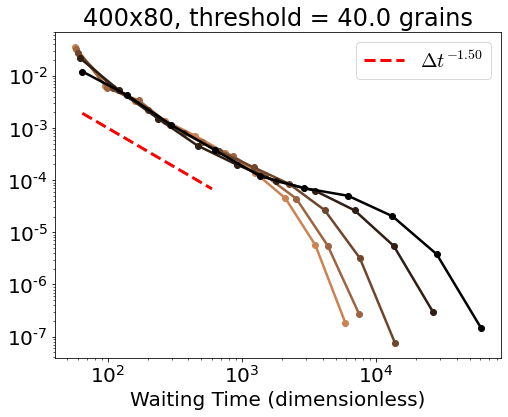

In [38]:
# Choose directory
idir = '../400x80/'
Nx = 400
Ny = 80

exp_plot= [
#     'q_1d000000e-02', # These don't exist yet
#     'q_1d513561e-02', # These don't exist yet
#     'q_2d290868e-02', # These don't exist yet
#     'q_3d467369e-02', # These don't exist yet
#     'q_5d248075e-02', # These don't exist yet
#     'q_7d943282e-02', # These don't exist yet
    'q_1d000000e-01', 
#     'q_1d359356e-01', 
    'q_1d847850e-01', 
#     'q_2d511886e-01', 
    'q_3d414549e-01', 
#     'q_4d641589e-01', 
    'q_6d309573e-01', 
#     'q_8d576959e-01', 
#     'q_1d165914e+00', 
#     'q_1d584893e+00', 
    'q_2d154435e+00', 
#     'q_2d928645e+00', 
#     'q_3d981072e+00', 
#     'q_5d411695e+00', 
#     'q_7d356423e+00', 
#     'q_1d000000e+01',
]

for thresh in [
#     10,
#     20,
    40,
#     80,
]:
    qm = []
    qs = []
    slopes_wt = []
    q8_ins_wt = []

    dt_min = 5e-3
    dt_max = 5
    pdf_min = 1e-3
    pdf_max = 5e2

    dt = 22.139999985694885 # Simulation parameter

    mindat = 2*dt
    # maxdat = 1.0

    nbins = 10

    thresh = thresh/(Nx*Ny)#20/(Nx*Ny)#10/(Nx*Ny)#9e-4 # Chosen by looking at PDFs, getting into the tail.

    plt.figure(figsize=(8,6))

    for ii,run in enumerate(reversed(exp_plot)):
        # Open 
        fname = str(glob.glob(idir+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')

        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]
        rho = 0.8
        dt = file['parameters']['dt'][()]
        if q_in<1:
            q_in_real = 1/int(1/q_in)
    #         print("q_in real",q_in_real)
        else:
            q_in_real = int(q_in)
    #         print("q_in > 1",int(q_in))

        # Normalize
        norm = dt**-1 * (4/3.) * np.pi * 1/float(Ny) * rho
        q8_in = norm*q_in_real

        # Get time-series ['bed_activity', 'q_out', 'time', 'tstep']
        time = file['scalars']['time'][()]
        tstep = file['scalars']['tstep'][()]
        q_out = file['scalars']['q_out'][()]
        q8_out = q_out*norm
        bed_activity = file['scalars']['bed_activity'][()]

        # Close file:
        file.close()

        ##############################

        # Choose data to plot:
        dt = np.diff(time)[0]
        dat = onoff_dist(bed_activity,dt,thresh)
        hist, bin_edges = np.histogram(np.log10(np.array(dat)),range=(np.log10(mindat),np.log10(np.max(dat))),density=True,bins=nbins)
        x = np.array([(bin_edges[i+1]+bin_edges[i])/2. for i in range(len(hist))])  #center of bins
        y = hist
    #     pdf,x = pdf_ccdf.pdf_ccdf(dat, n=nbins,xmin = mindat,xmax = max(dat),output='pdf')

        # Plot
    #     plt.figure(figsize=(8,6))
        plt.loglog(10**(x[(x>np.log10(mindat))&(y>0)]),10**(np.log10(y[(x>np.log10(mindat))&(y>0)])-x[(x>np.log10(mindat))&(y>0)]),ls='-',marker='o',label='',
                   color=cm.copper(cscale_qins(q_in_real/Ny,[0.1/Ny,10/Ny])),lw=2.5)
    #     plt.loglog(10**x,10**(np.log10(y)-x),ls='-',marker='o',label='',color=cm.copper(cscale_qins(q_in_real,qins)),lw=2.5)
    #     plt.loglog(x,pdf,marker='.',ls='',c = cm.copper(cscale_qins(q_in_real,qins)),label = r"$q_{in} =$ %.3e" % q_in_real,ms=10)

    #     plt.axvline(x=int(1/q_in),color = 'b')

    #     # Finite size effect cutoff
    #     nbeads = 2# Number of grains considered 'too small'
    #     xcutoff = nbeads/(Nx*Ny) # Five grains active total
    #     xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)
    #     plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))

    #     # Fit
    #     fitmax = 2e-3
    #     fitmin = xcutoff 
    #     xfit = x[(x<fitmax)&(x>fitmin)&(pdf>0)]
    #     pdffit = pdf[(x<fitmax)&(x>fitmin)&(pdf>0)]
    #     m,b = np.polyfit(np.log10(xfit),np.log10(pdffit),1)
    #     slopes_ba.append(m)
    #     q8_ins_ba.append(q8_in)

    m = -3/2.
    b = 1.
    xpl = np.logspace(np.min(x),np.log10(600),100)
    plt.plot(xpl,b*xpl**(m),'--r',label =r"$\Delta t^{%.2f}$" % m,lw=3)

    plt.legend()#loc=(1.01,0.0))
    plt.title("%sx%s, threshold = %s grains" % (Nx,Ny,thresh*Nx*Ny))
    plt.xlabel(r"Waiting Time (dimensionless)")
    # plt.xlabel(r"$q_{out}$")

    plt.show()
        
# slopes_ba = np.array(slopes_ba)
# q8_ins_ba = np.array(q8_ins_ba)

In [23]:
# # Choose directory
# idir = '../400x80/'
# Nx = 400
# Ny = 80

# exp_plot= [
# #     'q_1d000000e-02',  #
# #     'q_1d513561e-02',  #
# #     'q_2d290868e-02',  # These runs don't exist yet
# #     'q_3d467369e-02',  # 
# #     'q_5d248075e-02',  #
# #     'q_7d943282e-02',  #
#     'q_1d000000e-01', 
# #     'q_1d359356e-01', 
#     'q_1d847850e-01', 
# #     'q_2d511886e-01', 
#     'q_3d414549e-01', 
# #     'q_4d641589e-01', 
#     'q_6d309573e-01', 
# #     'q_8d576959e-01', 
# #     'q_1d165914e+00', 
# #     'q_1d584893e+00', 
#     'q_2d154435e+00', 
# #     'q_2d928645e+00', 
# #     'q_3d981072e+00', 
# #     'q_5d411695e+00', 
# #     'q_7d356423e+00', 
# #     'q_1d000000e+01',
# ]

# qm = []
# qs = []
# slopes_wt = []
# q8_ins_wt = []

# dt_min = 5e-3
# dt_max = 5
# pdf_min = 1e-3
# pdf_max = 5e2

# dt = 22.139999985694885 # Simulation parameter

# mindat = 2*dt
# # maxdat = 1.0

# nbin = 15

# thresh = 10/(Nx*Ny)#9e-4 # Chosen by looking at PDFs, getting into the tail.

# plt.figure(figsize=(8,6))

# for ii,run in enumerate(exp_plot):
#     # Open 
#     fname = str(glob.glob(idir+run+'/*_scalars.h5')[0])
#     file = h5py.File(fname,'r')
    
#     # Get parameters:
#     Nx = file['parameters']['Nx'][()]
#     Ny = file['parameters']['Ny'][()]
#     c_0 = file['parameters']['c_0'][()]
#     f = file['parameters']['f'][()]
#     q_in = file['parameters']['q_in'][()]
#     skipmax = file['parameters']['skipmax'][()]
#     rho = 0.8
#     dt = file['parameters']['dt'][()]
#     if q_in<1:
#         q_in_real = 1/int(1/q_in)
# #         print("q_in real",q_in_real)
#     else:
#         q_in_real = int(q_in)
# #         print("q_in > 1",int(q_in))
    
#     # Normalize
#     norm = dt**-1 * (4/3.) * np.pi * 1/float(Ny) * rho
#     q8_in = norm*q_in_real
    
#     # Get time-series ['bed_activity', 'q_out', 'time', 'tstep']
#     time = file['scalars']['time'][()]
#     tstep = file['scalars']['tstep'][()]
#     q_out = file['scalars']['q_out'][()]
#     q8_out = q_out*norm
#     bed_activity = file['scalars']['bed_activity'][()]
    
#     # Close file:
#     file.close()

#     ##############################

#     # Choose data to plot:
#     dt = np.diff(time)[0]
#     dat = onoff_dist(bed_activity,dt,thresh)
#     hist, bin_edges = np.histogram(np.log10(np.array(dat)),range=(np.log10(mindat),np.log10(np.max(dat))),density=True,bins=nbins)
#     x = np.array([(bin_edges[i+1]+bin_edges[i])/2. for i in range(len(hist))])  #center of bins
#     y = hist
# #     pdf,x = pdf_ccdf.pdf_ccdf(dat, n=nbins,xmin = mindat,xmax = max(dat),output='pdf')

#     # Plot
# #     plt.figure(figsize=(8,6))
#     plt.loglog(10**(x[(x>np.log10(mindat))&(y>0)]),10**(np.log10(y[(x>np.log10(mindat))&(y>0)])-x[(x>np.log10(mindat))&(y>0)]),ls='-',marker='o',label='',
#                color=cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),lw=2.5)
# #     plt.loglog(10**x,10**(np.log10(y)-x),ls='-',marker='o',label='',color=cm.copper(cscale_qins(q_in_real,qins)),lw=2.5)
# #     plt.loglog(x,pdf,marker='.',ls='',c = cm.copper(cscale_qins(q_in_real,qins)),label = r"$q_{in} =$ %.3e" % q_in_real,ms=10)

# #     # Finite size effect cutoff
# #     nbeads = 2# Number of grains considered 'too small'
# #     xcutoff = nbeads/(Nx*Ny) # Five grains active total
# #     xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)
# #     plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))

# #     # Fit
# #     fitmax = 2e-3
# #     fitmin = xcutoff 
# #     xfit = x[(x<fitmax)&(x>fitmin)&(pdf>0)]
# #     pdffit = pdf[(x<fitmax)&(x>fitmin)&(pdf>0)]
# #     m,b = np.polyfit(np.log10(xfit),np.log10(pdffit),1)
# #     slopes_ba.append(m)
# #     q8_ins_ba.append(q8_in)

# m = -3/2.
# b = 1.
# xpl = np.logspace(np.min(x),np.log10(600),100)
# plt.plot(xpl,b*xpl**(m),'--r',label =r"$\Delta t^{%.2f}$" % m,lw=3)


# plt.title("%sx%s, threshold = %s grains" % (Nx,Ny,thresh*Nx*Ny))
# plt.legend()#loc=(1.01,0.0))
# plt.xlabel(r"Waiting Time (dimensionless)")
# # plt.xlabel(r"$q_{out}$")

# plt.show()
        
# # slopes_ba = np.array(slopes_ba)
# # q8_ins_ba = np.array(q8_ins_ba)

## Random plots 

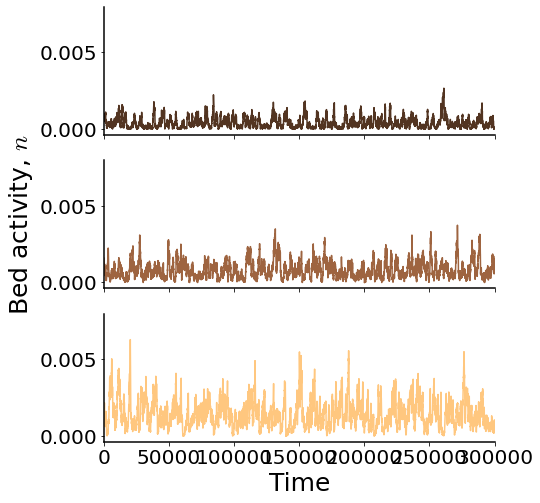

In [28]:
# Choose directory
idir = '../256x256/'
Nx = 256
Ny = 256

exp_plot = [
#     'q_1d000000e-01', ##
#     'q_1d359356e-01', 
#     'q_1d847850e-01', 
    'q_2d511886e-01', ##
#     'q_3d414549e-01', 
#     'q_4d641589e-01', 
#     'q_6d309573e-01', ##
    'q_8d576959e-01', 
#     'q_1d165914e+00', 
#     'q_1d584893e+00', 
#     'q_2d154435e+00', 
#     'q_2d928645e+00', 
#     'q_3d981072e+00', 
#     'q_5d411695e+00', 
#     'q_7d356423e+00', 
    'q_1d000000e+01',
]

nbin = 15
multf = 100
yint = 0.0

fig,ax = plt.subplots(3,1,figsize=(7,8),sharex='col',sharey='col')

for ii,run in enumerate(exp_plot):

    #####################
    #### TIME SERIES ####
    #####################
    for spine in ax[ii].spines.items():
        ax[ii].spines[spine[0]].set_linewidth(1.5)
    ax[ii].spines['right'].set_linewidth(0)
    ax[ii].spines['top'].set_linewidth(0)
    if ii==1:
#         ax[ii].set_ylabel(r"Sediment flux, $q^*$",fontsize=25)
        ax[ii].set_ylabel(r"Bed activity, $n$",fontsize=25)
    if ii==2:
        ax[ii].set_xlabel(r"Time",fontsize=25)
        #     plt.tight_layout()

        # Open 
    fname = str(glob.glob(idir+run+'/*_scalars.h5')[0])
    file = h5py.File(fname,'r')
    
    # Get parameters:
    Nx = file['parameters']['Nx'][()]
    Ny = file['parameters']['Ny'][()]
    c_0 = file['parameters']['c_0'][()]
    f = file['parameters']['f'][()]
    q_in = file['parameters']['q_in'][()]
    skipmax = file['parameters']['skipmax'][()]
    rho = 0.8
    dt = file['parameters']['dt'][()]
    if q_in<1:
        q_in_real = 1/int(1/q_in)
#         print("q_in real",q_in_real)
    else:
        q_in_real = int(q_in)
#         print("q_in > 1",int(q_in))
    
    # Normalize
    norm = dt**-1 * (4/3.) * np.pi * 1/float(Ny) * rho
    q8_in = norm*q_in_real
    
    # Get time-series ['bed_activity', 'q_out', 'time', 'tstep']
    t = file['scalars']['time'][()]
    tstep = file['scalars']['tstep'][()]
    q_out = file['scalars']['q_out'][()]
    q8_out = q_out*norm
    q = file['scalars']['bed_activity'][()]
    
    # Close file:
    file.close()
    
    ### TIME SERIES
    ax[ii].plot(t-t[0],q,color=cm.copper(cscale_qins(q_in_real/Ny,[0.1/Ny,10/Ny])),label = r'$\langle q^*_{in} \rangle = $ %.3e' % q8_in)
#     tshift= t[0]
    deltat = 100000 #500000
    ax[ii].set_xlim(0,3*deltat)
#     ax[ii].set_ylim(0,0.02)
#     if ii==0:
#         ax[ii].legend(title="Input flux",loc=1)
#     else:
#         ax[ii].legend(loc=1)

###########################
# plt.savefig(odir+"Fig2_1_SIM.png",bbox_inches= "tight",dpi=300)

plt.show()

<ipython-input-26-1ff231595ef7>:103: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fff9bd30340> has a label of '_line3' which cannot be automatically added to the legend.
  first_legend = pdf_ax.legend(handles=tslope,frameon=False,loc=1,fontsize=25)


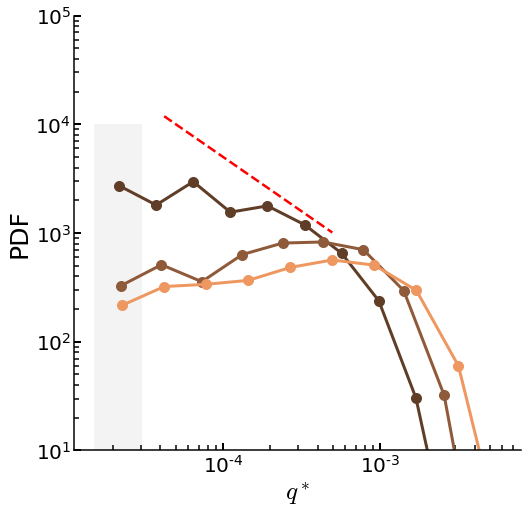

In [26]:
# Choose directory
idir = '../256x256/'
Nx = 256
Ny = 256

exp_plot = [
#     'q_1d000000e-01', ##
#     'q_1d359356e-01', 
#     'q_1d847850e-01', 
    'q_2d511886e-01', ##
#     'q_3d414549e-01', 
#     'q_4d641589e-01', 
#     'q_6d309573e-01', ##
    'q_8d576959e-01', 
#     'q_1d165914e+00', 
#     'q_1d584893e+00', 
#     'q_2d154435e+00', 
#     'q_2d928645e+00', 
#     'q_3d981072e+00', 
#     'q_5d411695e+00', 
#     'q_7d356423e+00', 
    'q_1d000000e+01',
]

nbin = 10
multf = 1
yint = 0.0


# Finite size effect cutoff
nbeads = 2# Number of grains considered 'too small'
xcutoff = nbeads/(Nx*Ny) # Five grains active total

# fig,(ax) = plt.subplots(1,1,figsize=(12,8))
fig, pdf_ax = plt.subplots(1,1,figsize=(8,8))
for ii,run in enumerate(exp_plot):
    # Open 
    fname = str(glob.glob(idir+run+'/*_scalars.h5')[0])
    file = h5py.File(fname,'r')
    
    # Get parameters:
    Nx = file['parameters']['Nx'][()]
    Ny = file['parameters']['Ny'][()]
    c_0 = file['parameters']['c_0'][()]
    f = file['parameters']['f'][()]
    q_in = file['parameters']['q_in'][()]
    skipmax = file['parameters']['skipmax'][()]
    rho = 0.8
    dt = file['parameters']['dt'][()]
    if q_in<1:
        q_in_real = 1/int(1/q_in)
#         print("q_in real",q_in_real)
    else:
        q_in_real = int(q_in)
#         print("q_in > 1",int(q_in))
    
    # Normalize
    norm = dt**-1 * (4/3.) * np.pi * 1/float(Ny) * rho
    q8_in = norm*q_in_real
    
    # Get time-series ['bed_activity', 'q_out', 'time', 'tstep']
    t = file['scalars']['time'][()]
    tstep = file['scalars']['tstep'][()]
    q_out = file['scalars']['q_out'][()]
    q8_out = q_out*norm
    q = file['scalars']['bed_activity'][()]
    
    # Close file:
    file.close()
    
    pdf, x = pdf_ccdf.pdf_ccdf(q[q>0], n=nbin, output='pdf')#,xmin = xcutoff,xmax = max(q), output='pdf')
    plt.loglog(x[pdf>0],pdf[pdf>0],marker='o',lw=3,ls='-',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q_{in} =$ %.3e" % q_in_real,ms=10)

#     plt.axvline(x= xcutoff,color='b')

    xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)
    plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))
#     if run=='q_6d309573e-01':
#         # For plotting example gaussian
#         x = np.logspace(np.log10(2e-3),np.log10(max(q)),1000)
#         mean = np.nanmean(q)
#         std = np.nanstd(q)
#         gauss = pdf_ax.loglog(x,(1/(std*np.sqrt(2*np.pi)))*np.exp(-0.5*(x-mean)**2/std**2),ls = '--',c='grey',zorder=-10,lw=2.5,label="Gaussian")
    

# pdf_ax.set_ylim(1e-1,1e4)
pdf_ax.set_ylim(1e1,1e5)
# pdf_ax.set_xlim(2e-3,3)
pdf_ax.tick_params(axis='both',which = 'both',direction='in')#,width=2)
for spine in pdf_ax.spines.items():
    pdf_ax.spines[spine[0]].set_linewidth(1.5)
pdf_ax.spines['right'].set_linewidth(0)
pdf_ax.spines['top'].set_linewidth(0)
pdf_ax.tick_params(width=2,length=7,which='major')
pdf_ax.tick_params(width=1.5,length=5,which='minor')
pdf_ax.set_ylabel(r"PDF",fontsize=25)
pdf_ax.set_xlabel(r"$q^*$",fontsize=25)
# plt.text(2.5e-3,8e1, "g",fontsize=25)

yexp = -1.
tslope = pdf_ax.loglog(x[(xcutoff<x)&(x<9e-4)], 10**(-0.3)*x[(xcutoff<x)&(x<9e-4)]**(yexp),ls='--',color='r',lw=2.5)#,
#               label = 'Theoretical \n PDF exponent \n at threshold \n of motion',lw=2.5)
first_legend = pdf_ax.legend(handles=tslope,frameon=False,loc=1,fontsize=25)
pdf_ax.add_artist(first_legend)
# pdf_ax.legend(handles=gauss,frameon=False,loc=3,fontsize=25)

###########################
# plt.savefig(odir+"Fig2_2.png",bbox_inches= "tight",dpi=300)

plt.show()